In [1]:
import torch
import torch_harmonics.distributed as dist
import torch_harmonics as th
import xarray as xr
import numpy as np
import xesmf as xe
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from subs1_utils import precompute_latitudes, bscst

import warnings
warnings.filterwarnings("ignore")

cmap = 'turbo'

In [2]:
### Define Spectral Truncation Desired and Consistent
###    Gausian Grid
zw = 63
mw = 63
jmax = 96
imax = 192
#
# Since the this is an annual cycle simulation the preprocessed data is relatively large and is saved on a data disk
#
outpath = '/Users/bkirtman/Work/Python/Scripts/AGCM/GitHubVersion/HeldSuarez/'
#
###
###
###
###
# Setup necessary element for interpolation onto model Gaussian Grid
# Get the Gaussian latitudes on equally spaced longitudes (xr.dataset)
cost_lg, wlg, lats = precompute_latitudes(jmax)
lats = 90-180*lats/(np.pi)
lons = np.linspace(0.0,360.0-360.0/imax,imax)
dlatlon = xr.Dataset({"lat": lats, "lon": lons})

# Instantiate  grid to spectral (dsht) and spectral to grid (disht) transforms
#
vsht = th.RealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
dsht = dist.DistributedRealSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
disht = dist.DistributedInverseRealSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
dvsht = dist.DistributedRealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)
divsht = dist.DistributedInverseRealVectorSHT(jmax, imax, lmax=mw, mmax=zw, grid="legendre-gauss", csphase=False)

In [3]:
### Grab Topography Data
###
url_topo = 'http://research.jisao.washington.edu/data_sets/elevation/elev.0.75-deg.nc'
ds_topo = xr.open_dataset(url_topo + '#mode=bytes', decode_times = False) # adding #mode=bytes because netcdf4 non-opendap URLrequeriment
del ds_topo['time']
data = ds_topo.data.squeeze()
data

<xarray.DataArray 'data' (lat: 241, lon: 480)>
[115680 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float32 0.0 0.75 1.5 2.25 3.0 ... 357.0 357.8 358.5 359.2
Attributes:
    units:      m
    long_name:  m

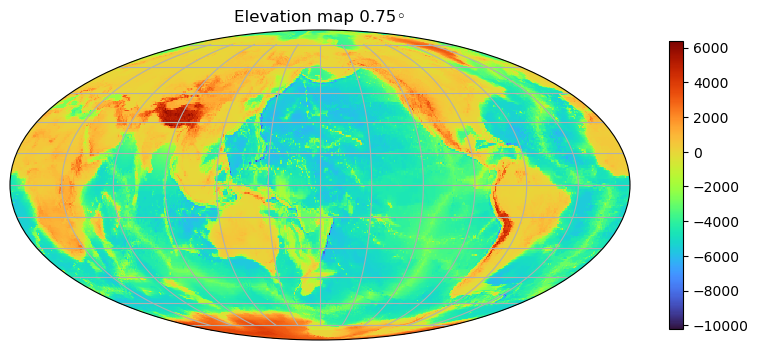

In [4]:
lon = np.linspace(-np.pi, np.pi, data.shape[1])
lat = np.linspace(np.pi/2., -np.pi/2., data.shape[0])
Lon, Lat = np.meshgrid(lon, lat)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection='mollweide')
cs = ax.pcolormesh(Lon, Lat, data, cmap=cmap)
ax.set_title("Elevation map 0.75◦")
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
fig.colorbar(cs, ax=ax, shrink=0.75)
plt.show()

In [5]:
regridder_topog = xe.Regridder(data, dlatlon,'bilinear')

In [6]:
topog_gg = regridder_topog(data)*9.8

In [7]:
topog_gg_dev = torch.from_numpy(np.where(topog_gg < 0.0, 0.0, topog_gg))
coeffs = dsht(topog_gg_dev)
topog_gg_r = disht(coeffs)

In [8]:
# Write out the spectral coefficients for topography to be read by
# the AGCM as a pickle file
#
torch.save(coeffs,outpath+'topog.spectral.pt')

In [9]:
#
# Now generature the vertical strucuture of temperature
# will neeed model vertical structure (si(kmax))
#
from subs1_utils import *
#
kmax = 26
delsig, si, sl, sikap, slkap, cth1, cth2, r1b, r2b = bscst(kmax)
#
#
temp_spec = torch.from_numpy(np.zeros((12,kmax,zw,mw)))
temp_gg = np.zeros((12,kmax,jmax,imax))
#
#   Radiative equilibrium temperature
#       varying surface temperature decreasing with
#       height with a lapse rate dTe/dz approx = -rlaps degrees/m
#       to a stratospheric temperature of tstrat
#
rlaps=6.8*1.0e-03
h0 = 8.2e+03
tstrat = 205.0 # fixed stratospheric temperature
deltemp = 60.0 # pole_to_equator temperature difference
deltheta = 10.0
kappa = 2.0/7.0
#
# Set Radiative Temperature Profile here. Need to use topography to reduce temperature based on altitude
#
# Calculate the radiative surface temperature as a function of latitude
#
temp_gg = np.zeros((kmax,jmax,imax))
sinlat = np.sin(lats*np.pi/180.0)
coslat = np.cos(lats*np.pi/180.0)
#
for j in range(jmax):
    for k in range(kmax):
        temp_gg[k,j,:] = (315.0 - deltemp*sinlat[j]*sinlat[j]-\
        deltheta*np.log(sl[k])*coslat[j]*coslat[j])*(sl[k]**kappa)
#
#
temp_gg = np.where(temp_gg < 200.0, 200.0, temp_gg)

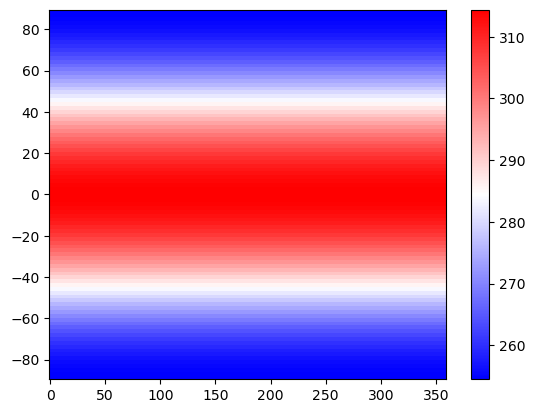

In [10]:
Lon, Lat = np.meshgrid(lons, lats)
plt.pcolormesh(Lon, Lat, temp_gg[kmax-1,:,:], cmap='bwr')
plt.colorbar()

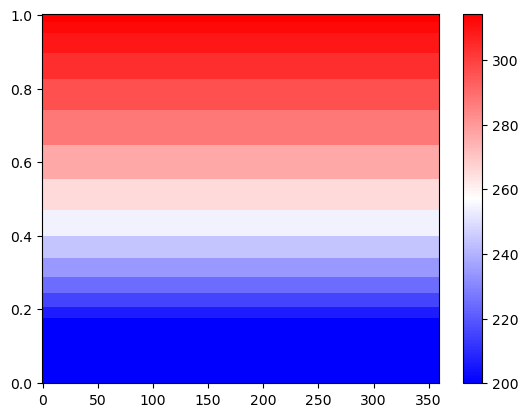

In [11]:
Lon, Zlev = np.meshgrid(lons, sl)
plt.pcolormesh(Lon, Zlev, temp_gg[:,48,:], cmap='bwr')
plt.colorbar()

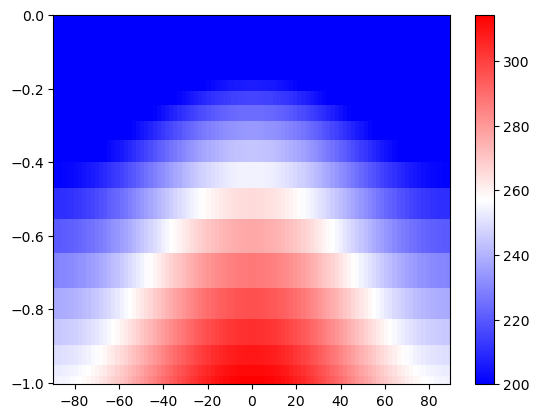

In [12]:
Lat, Zlev = np.meshgrid(lats, -sl)
plt.pcolormesh(Lat, Zlev, temp_gg[:,:,96], cmap='bwr')
plt.colorbar()

In [13]:
#
temp_coeffs = dsht(torch.from_numpy(temp_gg))

In [14]:
torch.save(temp_coeffs,outpath+'temp.spectral_RadiativeEquilibrium.pt')
torch.save(temp_gg,outpath+'temp.ggrid_RadiativeEquilibrium.pt')

In [15]:
ps = np.zeros((jmax,imax))
lnps_coeffs = dsht(torch.from_numpy(ps))
torch.save(lnps_coeffs,outpath+'lnps.spectral_RadiativeEquilibrium.pt')
print(['global mean lnps',lnps_coeffs[0,0]])

['global mean lnps', tensor(0.+0.j, dtype=torch.complex128)]


In [16]:
lnps_coeffs

tensor([[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]],
       dtype=torch.complex128)

In [17]:
##
## Following Held & Suarez the Newtonian Damping Coefficients are latitudinally
## Dependent. Here we produce those coeffiencients and convert into spectral form
##
ka = 1.0/(40.0*86400.0)
ks = 1/(4.0*86400.0)
slb = 0.7
vert = (sl-slb)/(1.0-slb)
vert = np.where(vert < 0.0,0.0, vert)
kt = np.zeros((kmax,jmax,imax))
for j in range(jmax):
    for k in range(kmax):
        kt[k,j,:] = ka + (ks - ka)*vert[k]*(coslat[j]**4.0)
#
cooling_coeffs = dsht(torch.from_numpy(kt))
torch.save(cooling_coeffs,outpath+'cooling.spectral_RadiativeEquilibrium.pt')
torch.save(kt,outpath+'cooling.ggrid_RadiativeEquilibrium.pt')

In [18]:
vert

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.28983323, 0.55562725, 0.76468158, 0.90154547,
       0.97510985])

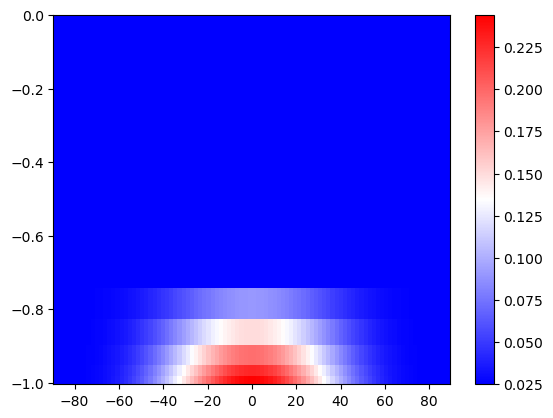

In [19]:
Lat, Zlev = np.meshgrid(lats, -sl)
plt.pcolormesh(Lat, Zlev, kt[:,:,96]*86400, cmap='bwr')
plt.colorbar()